In [2]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
#Import packages
import math
import random
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

from itertools import count
from collections import deque

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

import tqdm
from tqdm import tnrange, tqdm_notebook
from time import sleep
import os

#Import Custom Classes

from Source.nn_model_dqn import QNetwork
from Source.dqn_rcv_agent import Agent, ReplayBuffer, EpsilonGreedyStrategy
from Source.env_manager import EnvManager
from Source.misc_fun.utils import plot, get_moving_average, Generate_BeamDir, All_Exhaustive_RateMeas
from Source.PER import PrioritizedReplayBuffer

In [3]:
#Hyper-parameters
BUFFER_SIZE = int(1e5)      #replay buffer size
BATCH_SIZE = 128             #minibatch size
GAMMA = 0.999                #discount factor
ALPHA = 0.6                  #non-stationarity parameter
TAU = 1e-3                  #for soft update of target parameters
LR = 5e-4                   #learning rate
TEST_EVERY = 1600            #how often to test the network
eps_start = 1.0
eps_end = 0.01
eps_decay = 0.9985 #125e-6
test_loc = np.array([[100, 100, 0]])
PER_ALPHA = 0.6
PER_BETA = 0.4
PRIORITIZED_REPLAY = False

episodes = 4200 #3100 train, 500 test

test_episodes = 20
seed = 0                    #random seed number
episode_step_limit = 50
#%%
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

inp_fptr = open("ch_variation.txt")
ch_randvals = inp_fptr.read().splitlines()
ch_randvals = [np.complex(a.replace('i','j')) for a in ch_randvals]

In [4]:
print(ch_randvals[0])

#print(np.complex(ch_randvals[0].replace('i','j')))

(0.72152-0.88578j)


In [5]:
#Choose the environment
em = EnvManager(device, 'combrf-v2', seed)
available_actions = em.num_actions_available()
random.seed(seed)
state_size = em.state_size()
print(em.env.ch_model)
print(em.env.sc_xyz)
#Select the strategy
strategy = EpsilonGreedyStrategy(eps_start, eps_end, eps_decay, 3500)

if PRIORITIZED_REPLAY:
    beta_strategy = EpsilonGreedyStrategy(PER_BETA, 1.0, eps_decay, 3500)

#Initialize the agent
agent = Agent(strategy, state_size, available_actions, seed, device)

#Instantiate MemoryBuffer
if not PRIORITIZED_REPLAY:
    memory = ReplayBuffer(available_actions, BUFFER_SIZE, BATCH_SIZE, seed, device)
else:
    memory = PrioritizedReplayBuffer(available_actions, BUFFER_SIZE, BATCH_SIZE, PER_ALPHA,seed, device)

policy_net = QNetwork(state_size, available_actions, seed).to(device)
target_net = QNetwork(state_size, available_actions, seed).to(device)
print(policy_net)

#Initialize target_net weights to policy_net weights
target_net.load_state_dict(policy_net.state_dict())
target_net.eval() #Set the target_net in eval mode

#Select the optimizer
optimizer = optim.Adam(params=policy_net.parameters(), lr=LR)

uma-los
[]
QNetwork(
  (hidden_layers): ModuleList(
    (0): Linear(in_features=5, out_features=400, bias=True)
    (1): Linear(in_features=400, out_features=400, bias=True)
    (2): Linear(in_features=400, out_features=64, bias=True)
  )
  (softmax): Softmax(dim=1)
  (output): Linear(in_features=64, out_features=8, bias=True)
)


## Test with random untrained actions

In [6]:
obs = em.env.reset(np.exp(1j * 2 * np.pi * 0.6))
print(obs)
ep_rwd=[]
while True:
    action = random.randrange(em.env.action_space.n)
    
    obs, rwd, done, _ = em.env.step(action)
    print(action)
    ep_rwd.append(rwd)
    if done:
        break
        
print("Episode score: {}".format(np.sum(ep_rwd)))

[[ 0.375       0.5        -0.1        -0.1         0.95555556]]
6
6
Episode score: 1.0


In [7]:
moving_rpts = [[np.array([rp_loc])] for rp_loc in em.env.sc_xyz]

#print("Initial: \n", moving_rpts)

for i in range(2):
    for ndx in range(len(moving_rpts)):
        if (ndx == 0) or (ndx == 1):
            last_loc = moving_rpts[ndx][-1]
            new_loc = np.array([[last_loc[0][0]+em.env.rx_stepsize, last_loc[0][1], last_loc[0][2]]]) 
            moving_rpts[ndx].append(new_loc)
        elif (ndx == 2) or (ndx == 3):
            last_loc = moving_rpts[ndx][-1]
            new_loc = np.array([[last_loc[0][0], last_loc[0][1]-em.env.rx_stepsize, last_loc[0][2]]]) 
            moving_rpts[ndx].append(new_loc)

print("After adding moving patterns: ", moving_rpts)



After adding moving patterns:  []


In [8]:
eps_scpts = []

for i in range(episodes):
    #print(random.choice(moving_rpts[0]))
    sc_pts = np.array([random.choice(moving_rpts[ndx])[0] for ndx in range(len(moving_rpts))])
    eps_scpts.append(sc_pts)

#print(eps_scpts)

In [9]:
print(eps_scpts[7])

[]


## Train the DQN agent

Episode 4100,	Score: 1.00, eps: 0.01, moving avg_rwd: 0.9300000071525574, ep_loss: 32.712565422058105356842041015625418
test_eps: 4100, eps_rwd: 1.0
TX loc: [[-100 -100   20]]
SC_xyz: []
TX dirs:  [22.500000000000004, 22.500000000000004]
RX dirs:  [157.5, 135.0]
data rates: [11.401606878569295, 16.88292162521558]
min exh_rate: 9.305279779097432, min_action_ndx: 3
max exh_rate: 16.88292162521558, max_action_ndx: 5

Episode 4101,	Score: 1.00, eps: 0.01, moving avg_rwd: 0.9399999976158142, ep_loss: 36.721900939941406
test_eps: 4101, eps_rwd: 1.0
TX loc: [[-100 -100   20]]
SC_xyz: []
TX dirs:  [45.0, 45.0]
RX dirs:  [157.5, 135.0]
data rates: [18.163146691455992, 23.64497806635829]
min exh_rate: 16.06508691174587, min_action_ndx: 3
max exh_rate: 23.64497806635829, max_action_ndx: 5

Episode 4102,	Score: 1.00, eps: 0.01, moving avg_rwd: 0.9399999976158142, ep_loss: 39.87179374694824
test_eps: 4102, eps_rwd: 1.0
TX loc: [[-100 -100   20]]
SC_xyz: []
TX dirs:  [67.5, 67.5]
RX dirs:  [67.5, 13

Episode 4126,	Score: 1.00, eps: 0.01, moving avg_rwd: 0.9100000262260437, ep_loss: 43.24032211303711
test_eps: 4126, eps_rwd: 1.0
TX loc: [[-100 -100   20]]
SC_xyz: []
TX dirs:  [67.5, 67.5]
RX dirs:  [180.0, 135.0]
data rates: [12.490705435853355, 18.049563335202258]
min exh_rate: 10.470662984044425, min_action_ndx: 3
max exh_rate: 18.049563335202258, max_action_ndx: 5

Episode 4127,	Score: 1.00, eps: 0.01, moving avg_rwd: 0.9100000262260437, ep_loss: 35.62831687927246
test_eps: 4127, eps_rwd: 1.0
TX loc: [[-100 -100   20]]
SC_xyz: []
TX dirs:  [90.0, 90.0]
RX dirs:  [22.500000000000004, 135.0]
data rates: [10.915932646654182, 15.188333349131703]
min exh_rate: 7.6157567851035965, min_action_ndx: 3
max exh_rate: 15.188333349131703, max_action_ndx: 5

Episode 4128,	Score: 1.00, eps: 0.01, moving avg_rwd: 0.9100000262260437, ep_loss: 36.60603618621826
test_eps: 4128, eps_rwd: 1.0
TX loc: [[-100 -100   20]]
SC_xyz: []
TX dirs:  [112.5, 112.5]
RX dirs:  [22.500000000000004, 135.0]
data rat

Episode 4150,	Score: 1.00, eps: 0.01, moving avg_rwd: 0.8899999856948853, ep_loss: 30.590717315673828
test_eps: 4150, eps_rwd: 1.0
TX loc: [[-100 -100   20]]
SC_xyz: []
TX dirs:  [67.5, 67.5]
RX dirs:  [45.0, 135.0]
data rates: [12.360725783223808, 18.059484458034877]
min exh_rate: 10.48057717565232, min_action_ndx: 3
max exh_rate: 18.059484458034877, max_action_ndx: 5

Episode 4151,	Score: 0.00, eps: 0.01, moving avg_rwd: 0.8799999952316284, ep_loss: 76.44734191894531
test_eps: 4151, eps_rwd: 0.0
TX loc: [[-100 -100   20]]
SC_xyz: []
TX dirs:  [90.0, 90.0, 90.0, 90.0]
RX dirs:  [67.5, 135.0, 67.5, 135.0]
data rates: [9.901851581918635, 16.171639324460415, 9.901851581918635, 16.171639324460415]
min exh_rate: 8.59544234794822, min_action_ndx: 3
max exh_rate: 16.171639324460415, max_action_ndx: 5

Episode 4152,	Score: 1.00, eps: 0.01, moving avg_rwd: 0.8799999952316284, ep_loss: 40.04366111755371
test_eps: 4152, eps_rwd: 1.0
TX loc: [[-100 -100   20]]
SC_xyz: []
TX dirs:  [112.5, 112.5]


Episode 4173,	Score: 1.00, eps: 0.01, moving avg_rwd: 0.8500000238418579, ep_loss: 33.28519821166992
test_eps: 4173, eps_rwd: 1.0
TX loc: [[-100 -100   20]]
SC_xyz: []
TX dirs:  [45.0, 45.0]
RX dirs:  [45.0, 135.0]
data rates: [17.691719107742205, 23.390740143788666]
min exh_rate: 15.81085302302192, min_action_ndx: 3
max exh_rate: 23.390740143788666, max_action_ndx: 5

Episode 4174,	Score: 1.00, eps: 0.01, moving avg_rwd: 0.8500000238418579, ep_loss: 32.8073844909668
test_eps: 4174, eps_rwd: 1.0
TX loc: [[-100 -100   20]]
SC_xyz: []
TX dirs:  [67.5, 67.5]
RX dirs:  [45.0, 135.0]
data rates: [12.951574657253417, 18.650423749531647]
min exh_rate: 11.071178840792044, min_action_ndx: 3
max exh_rate: 18.650423749531647, max_action_ndx: 5

Episode 4175,	Score: 1.00, eps: 0.01, moving avg_rwd: 0.8500000238418579, ep_loss: 39.338592529296875
test_eps: 4175, eps_rwd: 1.0
TX loc: [[-100 -100   20]]
SC_xyz: []
TX dirs:  [90.0, 90.0]
RX dirs:  [67.5, 135.0]
data rates: [8.365598165865837, 14.63255

Episode 4197,	Score: 1.00, eps: 0.01, moving avg_rwd: 0.8600000143051147, ep_loss: 31.86862564086914
test_eps: 4197, eps_rwd: 1.0
TX loc: [[-100 -100   20]]
SC_xyz: []
TX dirs:  [45.0, 45.0]
RX dirs:  [180.0, 135.0]
data rates: [15.890530695870687, 21.449610720998027]
min exh_rate: 13.869794504888462, min_action_ndx: 3
max exh_rate: 21.449610720998027, max_action_ndx: 5

Episode 4198,	Score: 1.00, eps: 0.01, moving avg_rwd: 0.8600000143051147, ep_loss: 25.162209510803223
test_eps: 4198, eps_rwd: 1.0
TX loc: [[-100 -100   20]]
SC_xyz: []
TX dirs:  [67.5, 67.5]
RX dirs:  [157.5, 135.0]
data rates: [12.141009370528927, 17.622533241132952]
min exh_rate: 10.043981231515438, min_action_ndx: 3
max exh_rate: 17.622533241132952, max_action_ndx: 5

Episode 4199,	Score: 1.00, eps: 0.01, moving avg_rwd: 0.8600000143051147, ep_loss: 32.52572154998779
test_eps: 4199, eps_rwd: 1.0
TX loc: [[-100 -100   20]]
SC_xyz: []
TX dirs:  [90.0, 90.0]
RX dirs:  [157.5, 135.0]
data rates: [10.484990269254286, 15

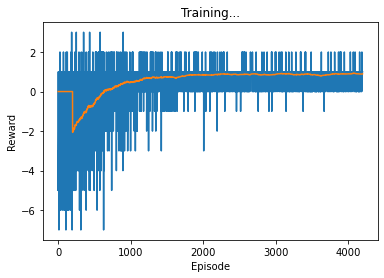

No. of false positives: 0


In [10]:
ep_rewards = []
test_rewards = []
test_data_rates = []
test_eps_iters=[]
test_minexh_rates = []
test_maxexh_rates = []
false_positives =0
policy_net.train()
test_txbdir = 0

outer = tqdm.notebook.tqdm(total=episodes, desc='training loop: ', position=0)
train_steps = 0
for episode in range(episodes):
    
    #if(eps <= 0.1):
    #    em.env.sc_xyz=np.array([])
    #    em.env.ch_model = 'uma-los'
    #if ((episode+1) == 3500):
    #    em.env.ch_model = 'uma-los'
    #    em.env.sc_xyz = np.array([])
        #train_steps = 0
        #strategy =EpsilonGreedyStrategy(1.0, eps_end, 0.997)#0.1
    #if ((episode+1) == 3900):
    #    train_steps=0
    #    strategy =EpsilonGreedyStrategy(1.0, eps_end, 0.9983, 3500)#0.1
    #    if PRIORITIZED_REPLAY:
    #        beta_strategy = EpsilonGreedyStrategy(PER_BETA, 1.0, eps_decay, 3500)
    #em.env.sc_xyz = eps_scpts[episode]
    if ((episode+1) >= 4100):    
        obs = em.test_reset(np.array([[-100,-100,20]]), test_txbdir, em.env.sc_xyz, ch_randvals[episode])
        test_txbdir = (test_txbdir + 1) % em.env.N_tx
    else:
        obs = em.reset(ch_randvals[episode])

    
    ep_loss = 0.0
    ep_rwd = 0.0
    timestep = 0
    tx_dirs = []
    rx_dirs = []
    data_rates =[]
    #agent.current_step +=1
    train_steps +=1
    eps = strategy.get_exploration_rate(train_steps)
    if PRIORITIZED_REPLAY:
        beta = beta_strategy.get_exploration_rate(train_steps)
    
    while True:
        tx_dirs.append(em.env.tx_bdir*(180/np.pi))
        rx_dirs.append(em.env.rx_bdir*(180/np.pi))
        data_rates.append(em.env.rate)

        action = agent.act(obs, policy_net, eps)
        next_obs, reward, done, _ = em.step(action)
        #agent.step(obs, action, reward, next_obs, done)
        ep_rwd += reward.item()
        
        min_exh_rate, max_exh_rate,min_action_ndx,max_action_ndx,_,_ = em.env.get_minmax_exhrate(ch_randvals[episode])
        '''
        if(np.all(em.env.tx_loc == np.array([[100,100,0]]))):
            print("ch_model: {}, sc_xyz: {}, min_exh_rate: {}, max_exh_rate: {}, min_action_ndx: {}, max_action_ndx: {}".format(em.env.ch_model, em.env.sc_xyz, min_exh_rate, max_exh_rate, min_action_ndx, max_action_ndx))
        '''   
        memory.add(obs, action, reward, next_obs, done)
        obs = next_obs
        
        if memory.can_provide_sample():
            
            if PRIORITIZED_REPLAY:
                experiences = memory.sample(beta)
                observations, actions, rewards, next_observations, dones, weights, batch_indices = experiences
            else:
                experiences = memory.sample()
                observations, actions, rewards, next_observations, dones = experiences
                weights, batch_indices = torch.tensor(np.ones_like(rewards.cpu().data.numpy())).to(device), None
            
            #print(states.shape, states.dtype)
            #print(actions.unsqueeze(-1).shape)
            current_q_values = policy_net(observations).gather(1,index=actions.unsqueeze(-1))#(1-ALPHA)*
            
            next_q_values = target_net(next_observations).detach().max(1)[0]
            target_q_values = ((next_q_values*GAMMA) + rewards)
            #print(policy_net(observations).type())
            #print(target_q_values.unsqueeze(1).type())
            #loss = F.mse_loss(current_q_values, target_q_values.unsqueeze(1).float())
            td_errors = ALPHA*(target_q_values.unsqueeze(1).float()-current_q_values)
            loss = F.mse_loss(torch.zeros(current_q_values.size()).to(device), ALPHA*(target_q_values.unsqueeze(1).float()-current_q_values),  reduction=None)
            #weighted_loss = torch.mean(weights*loss)
            #print("loss: ", loss)
            #loss = ALPHA*loss
            #ep_loss += weighted_loss.item()
            ep_loss += loss.item()
            
            optimizer.zero_grad()
            #weighted_loss.backward()
            loss.backward()
            optimizer.step()
            
            if PRIORITIZED_REPLAY:
                comp_errors = np.array([x[0] for x in td_errors.cpu().data.numpy()])
                new_priorities = np.abs(comp_errors) + 1e-6
                #print(new_priorities)
                memory.update_priorities(batch_indices.cpu().data.numpy(), new_priorities)
            
        timestep +=1
        if done:
            ep_rewards.append(ep_rwd)
            moving_avg_rwd = get_moving_average(100, ep_rewards)
            print('\rEpisode {},\tScore: {:.2f}, eps: {}, moving avg_rwd: {}, ep_loss: {}'.format(episode+1, ep_rwd, eps, moving_avg_rwd[-1], ep_loss), end="\r")
            #plot(episode_rewards, 100)
            
            #if(((episode+1) >= 6000) or (3000 <= (episode+1)<=3500)):
            if((episode+1) >= 4100):
                
                test_data_rates.append(data_rates[-1])
                test_eps_iters.append(timestep)
                test_minexh_rates.append(min_exh_rate)
                test_maxexh_rates.append(max_exh_rate)
                
                #if (timestep > 3):
                #    if(timestep >=8):
                #        false_positives +=1
                #if (min_exh_rate == max_exh_rate):
                print("\ntest_eps: {0}, eps_rwd: {1}".format(episode+1, ep_rwd))
                print("TX loc: {}".format(em.env.tx_loc))
                print("SC_xyz: {}".format(em.env.sc_xyz))
                print("TX dirs: ", tx_dirs)
                print("RX dirs: ", rx_dirs)
                print("data rates: {}".format(data_rates))
                print("min exh_rate: {}, min_action_ndx: {}".format(min_exh_rate, min_action_ndx))
                print("max exh_rate: {}, max_action_ndx: {}\n".format(max_exh_rate, max_action_ndx))
                
            timestep = 0
            break
            
        #print("timestep: {}".format(timestep))
    #if episode % UPDATE_EVERY == 0:
    #    target_net.load_state_dict(policy_net.state_dict())
    for local_param, target_param in zip(policy_net.parameters(), target_net.parameters()):
        target_param.data.copy_(TAU*local_param.data + (1.0-TAU)*target_param.data)
    
    
    '''    
    if ((episode == 0) or (episode+1) == 3100) or (((episode+1) > 3100) and ((train_steps) % (TEST_EVERY) == 0)):
        #test some episodes to check the performance
        policy_net.eval()
        test_ep_rwds = []
        for test_eps in range(test_episodes):
            obs = em.test_reset(test_loc, em.env.action_space.sample(), em.env.sc_xyz, ch_randvals[episode+test_eps+1])
            test_score=0
            tx_dirs = []
            rx_dirs = []
            data_rates =[]
            step = 0
            done = False
            while not done:
                action = policy_net(obs).argmax(dim=1).to(device)#agent.act(state_tensor, policy_net)
                #print("timestep: ",step, policy_net(obs),policy_net(obs).size(), action)
                tx_dirs.append(em.env.tx_bdir*(180/np.pi))
                rx_dirs.append(em.env.rx_bdir*(180/np.pi))
                data_rates.append(em.env.rate)
                next_obs, reward, done, _ = em.step(action)
                step+=1
                print("\ntstep: {0}, obs: {1}, action: {2}, next_obs: {3}, rwd: {4}, done: {5}".format(step, obs.cpu().data.numpy(), action.cpu().data.numpy(), next_obs.cpu().data.numpy(), reward.item(), done.item()))
                test_score+=reward.item()
                obs = next_obs
            
            print("test_eps: {0}, eps_rwd: {1}".format(test_eps+1, test_score))
            print("TX loc: {}".format(em.env.tx_loc))
            print("TX dirs: ", tx_dirs)
            print("RX dirs: ", rx_dirs)
            print("data rates: {}".format(data_rates))
            min_exh_rate, max_exh_rate,min_action_ndx,max_action_ndx,_,_ = em.env.get_minmax_exhrate(ch_randvals[episode+test_eps+1])
            print("min exh_rate: {}, min_action_ndx: {}".format(min_exh_rate, min_action_ndx))
            print("max exh_rate: {}, max_action_ndx: {}".format(max_exh_rate, max_action_ndx))
            
            test_ep_rwds.append(test_score)
            test_rewards.append(test_score)
            test_data_rates.append(data_rates[-1])
            test_minexh_rates.append(min_exh_rate)
            test_maxexh_rates.append(max_exh_rate)
            
        print("Average test_ep_score: {}\n".format(np.mean(test_ep_rwds)))
        policy_net.train()
        #agent.current_step=0
        train_steps = 0
        strategy =EpsilonGreedyStrategy(0.5, eps_end, 0.997)#0.1
    else:
        test_rewards.append(0)
        test_data_rates.append(0)
        test_minexh_rates.append(0)
        test_maxexh_rates.append(0)
    '''
    # update tqdm bar
    outer.update(1)
    
torch.save(policy_net.state_dict(), 'checkpoint.pth')

#timer.finish()
plot(ep_rewards, 200, test_rewards)
print("No. of false positives: {}".format(false_positives))

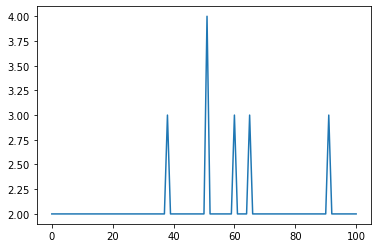

2.0594059405940595 101


In [11]:
fig=plt.figure()
min_ndx=0
max_ndx=500
plt.plot(test_eps_iters[min_ndx:max_ndx])
plt.show()
print(np.mean(test_eps_iters), len(test_eps_iters))

In [12]:
print(em.env.ch_model)
print(em.env.sc_xyz)

uma-los
[]


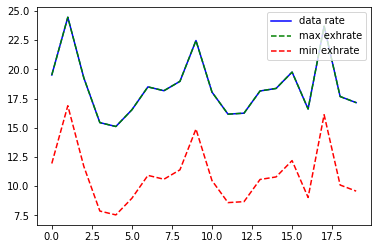

In [13]:
fig = plt.figure()
min_ndx=40
max_ndx=60
plt.plot(np.arange(len(test_data_rates[min_ndx:max_ndx])), test_data_rates[min_ndx:max_ndx], 'b', np.arange(len(test_data_rates[min_ndx:max_ndx])), test_maxexh_rates[min_ndx:max_ndx], 'g--',  np.arange(len(test_data_rates[min_ndx:max_ndx])), test_minexh_rates[min_ndx:max_ndx], 'r--')

plt.legend(['data rate','max exhrate', 'min exhrate'])
plt.show()

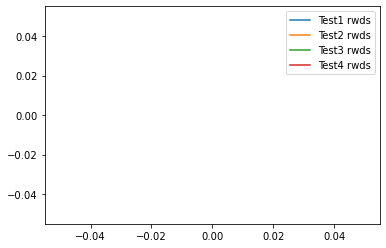

[16.88292162521558, 23.64497806635829, 18.22649425099079, 16.456169140806583, 15.590664601819883, 17.295032366891892, 17.432314031242054, 17.02473244035519, 16.178785016826016, 22.15403499706754, 17.793754170440483, 15.855015795888791, 17.56748371517776, 15.945142965719619, 19.706838796005005, 16.589172505458325, 17.373745145707392, 21.824716227017422, 17.770610561193635, 14.999852131737978, 18.429801514985183, 17.663702214512007, 18.144643796752575, 14.399125591800901, 18.498293570564655, 23.261962224944046, 18.049563335202258, 15.188333349131703, 15.886517769415642, 16.86783224105192, 18.74572912008712, 16.436437419078413, 20.05382068753312, 23.153016170874576, 16.498360522957444, 15.823079893956471, 19.226817520431382, 16.875088380428533, 18.133962786962506, 17.680310238374986, 19.525358535397338, 24.471132624801292, 19.2749494065386, 15.446463665542444, 15.113543468641298, 16.5440162611215, 18.506414531896223, 18.177825195439016, 18.981802494767273, 22.47516926357562, 18.0594844580

In [14]:
fig = plt.figure()
plt.plot(np.arange(len(test_rewards[0:20])), test_rewards[0:20], np.arange(len(test_rewards[3080:3140])), test_rewards[3080:3140], np.arange(len(test_rewards[4650:4740])), test_rewards[4650:4740], np.arange(len(test_rewards[6230:])), test_rewards[6230:])
#plt.plot()
plt.legend(['Test1 rwds', 'Test2 rwds', 'Test3 rwds', 'Test4 rwds'])
plt.show()

print(test_data_rates)

In [15]:
print(test_rewards[6250:])

[]


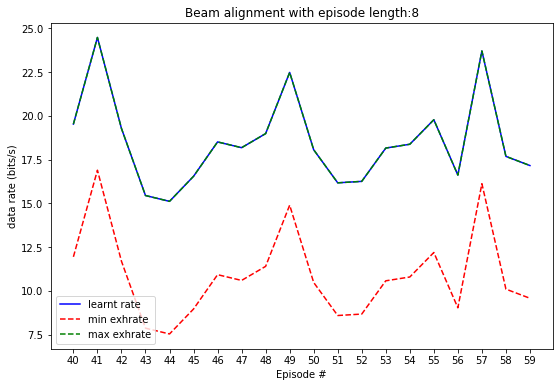

In [16]:
fig = plt.figure(figsize=[9, 6])
min_ndx=40
max_ndx=60
plt.plot(np.arange(len(test_data_rates[min_ndx:max_ndx])), test_data_rates[min_ndx:max_ndx], 'b', np.arange(len(test_data_rates[min_ndx:max_ndx])), test_minexh_rates[min_ndx:max_ndx], 'r--', np.arange(len(test_data_rates[min_ndx:max_ndx])), test_maxexh_rates[min_ndx:max_ndx], 'g--')
#plt.plot(np.arange(len(test_data_rates[3080:3140])), test_data_rates[3080:3140], 'b', np.arange(len(test_data_rates[3080:3140])), test_minexh_rates[3080:3140], 'r--', np.arange(len(test_data_rates[3080:3140])), test_maxexh_rates[3080:3140],'g--')
#plt.plot(np.arange(len(test_data_rates[4650:4740])), test_data_rates[4650:4740], 'b', np.arange(len(test_data_rates[4650:4740])), test_minexh_rates[4650:4740], 'r--', np.arange(len(test_data_rates[4650:4740])), test_maxexh_rates[4650:4740],'g--')
#plt.plot(np.arange(len(test_data_rates[6230:])), test_data_rates[6230:], 'b', np.arange(len(test_data_rates[6230:])), test_minexh_rates[6230:], 'r--', np.arange(len(test_data_rates[6230:])), test_maxexh_rates[6230:],'g--')

plt.xticks(np.arange(0, max_ndx-min_ndx), [str(x) for x in np.arange(min_ndx, max_ndx)])
plt.legend(['learnt rate','min exhrate', 'max exhrate'])
plt.xlabel('Episode #')
plt.ylabel('data rate (bits/s)')
plt.title('Beam alignment with episode length:{}'.format(em.env.goal_steps))
plt.show()

In [17]:
print(test_data_rates[250:500])
print(test_maxexh_rates[250:500])
#print(test_maxexh_rates[3080:3140])

[]
[]


In [18]:
print(test_data_rates[4650:4740])
print(test_maxexh_rates[4650:4740])

[]
[]


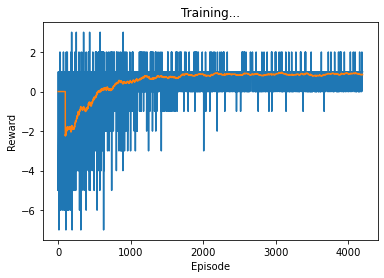

[-3.0, -5.0, 1.0, -5.0, -4.0, -5.0, -3.0, -4.0, -2.0, -1.0, -4.0, -7.0, -6.0, -6.0, -4.0, -2.0, -4.0, -2.0, 0.0, -6.0, -4.0, -3.0, 1.0, -3.0, 1.0, 2.0, -3.0, -3.0, -5.0, -5.0, -1.0, -5.0, -6.0, -5.0, -4.0, -1.0, -1.0, -3.0, -1.0, -2.0, 1.0, -3.0, 1.0, 0.0, -4.0, 1.0, -5.0, -3.0, 0.0, -2.0, -3.0, 0.0, -4.0, 1.0, -3.0, -1.0, -6.0, -2.0, -1.0, -3.0, -2.0, -1.0, -4.0, -1.0, 0.0, -1.0, -4.0, 0.0, 1.0, -1.0, -2.0, -1.0, 1.0, 2.0, 1.0, -2.0, 1.0, 0.0, -3.0, 1.0, -2.0, -5.0, 0.0, -6.0, 1.0, -6.0, -3.0, -3.0, -3.0, -6.0, 0.0, -1.0, -1.0, -3.0, -4.0, 0.0, -2.0, -4.0, 1.0, -3.0]
[ 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
  0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
  0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
  0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
  0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
  0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.

In [19]:
#import pickle

#memory.save('memory_checkpoint.pth')
plot(ep_rewards, 100, test_rewards)
print(ep_rewards[:100])
moving_avg_rwd = get_moving_average(100, ep_rewards[:100])
print(moving_avg_rwd)

## Test the DQN agent

In [20]:
policy_net.load_state_dict(torch.load('checkpoint.pth'))

test_ep_rwds=[]
tx_dirs=[]
rx_dirs = []
data_rates = []
test_obs = []
test_cap = []
policy_net.eval()
for i_episode in range(1):
    
    obs = em.reset()
    print("observation: ", obs)
    step = 0
    score = 0
    done = False
    while True:
        #if(step <=1):
        test_obs.append(obs.cpu().data.numpy())
        action = policy_net(obs).argmax(dim=1).to(device)#agent.act(state_tensor, policy_net)
        print("timestep: ",step, policy_net(obs),policy_net(obs).size(), action)
        tx_dirs.append(em.env.tx_bdir)
        rx_dirs.append(em.env.rx_bdir)
        data_rates.append(em.env.rate)
        if done:
            break
        next_obs, reward, done, _ = em.step(action)
        step+=1
        test_ep_rwds.append(reward.item())
        obs = next_obs
        
        
print("TX loc: {}".format(em.env.tx_loc))
print("Test episode score: {}".format(np.sum(test_ep_rwds)))

from Source.misc_fun.geometry import cart2sph
(az_aod, el_aod, temp) = cart2sph(em.env.rx_loc[0, 0] - em.env.tx_loc[0, 0], em.env.rx_loc[0, 1] -
                                                          em.env.tx_loc[0, 1], em.env.rx_loc[0, 2] -em.env.tx_loc[0, 2])
print("TX dir: {}".format([x*(180/np.pi) for x in tx_dirs]))
print("RX dirs: {}".format([x*(180/np.pi) for x in rx_dirs]))
print("Individual rwds: {}".format(test_ep_rwds))
print("Data rates: {}".format(data_rates))
print("Exhaustive rate: {}".format(em.env.get_exh_rate()))


TypeError: reset() missing 1 required positional argument: 'ch_randval'

In [ ]:
print(test_obs)

In [ ]:
em.env.BeamSet[4]*(180/np.pi)

In [ ]:
'(' + str(em.env.BeamSet[4]*(180/np.pi)) + ',' + str(em.env.BeamSet[3]*(180/np.pi)) + ')'

In [ ]:
from Source.misc_fun.utils import plotbeam

print(tx_dirs)
print(rx_dirs)
for tx_ang, rx_ang in zip(tx_dirs, rx_dirs):
    tx_theta, tx_gr = plotbeam(tx_ang, em.env.N_tx)
    rx_theta, rx_gr = plotbeam(rx_ang, em.env.N_rx)
    ax1 = plt.subplot(122, projection='polar')
    ax1.plot(tx_theta, tx_gr)

    ax2 = plt.subplot(121, projection='polar')
    ax2.plot(rx_theta, rx_gr)

    plt.show()




## Display all exhaustive rate measurements from env

In [ ]:
tx_locs = [np.array([[x, y, 0]]) for x in em.env.rx_xcov for y in em.env.rx_ycov]
verts = All_Exhaustive_RateMeas(tx_locs, 8, 8)

from mpl_toolkits.mplot3d import Axes3D  # noqa: F401 unused import
from matplotlib.collections import PolyCollection
import matplotlib.pyplot as plt
from matplotlib import colors as mcolors

fig = plt.figure()
ax = fig.gca(projection='3d')
poly = PolyCollection(verts[:4], facecolors=['r', 'g', 'b', 'y'], alpha=0.6)
print(len(verts))
print(verts[0:2])
#print(np.array(tx_locs[:4]))
ax.add_collection3d(poly, zs=np.arange(1,5), zdir='y')

ax.set_xlabel('X (beam pairs)')
ax.set_ylabel('Y (tx_locs)')
ax.set_zlabel('Z (data rates)')
ax.set_xlim(0, 10)
ax.set_ylim(1, 5)
ax.set_zlim(10, 30)

plt.show()

In [ ]:
#Find the best exhaustive beam for every location, tx_ndx in rx coverage area
def Find_Exh_LocBeams(verts, N_tx, N_rx):
    best_exhbeam_indices = []
    best_exh_rates =[]
    beam_ndx_loc_rates = []
    for loc_ndx in range(len(verts)):
        beam_ndx_rates = []
        for ndx in range(len(verts[loc_ndx])):
            tx_ndx = int((verts[loc_ndx][ndx][0]-1) / N_tx)
            rx_ndx = (verts[loc_ndx][ndx][0]-1) % N_rx
            beam_ndx_rates.append([tx_ndx, rx_ndx, verts[loc_ndx][ndx][1]])
        beam_ndx_loc_rates.append(beam_ndx_rates)

    #print(beam_ndx_rates)
    for tx_ndx in range(N_tx):

        for loc_ndx  in range(len(beam_ndx_loc_rates)):
            best_rate = 0.0
            best_rx_ndx = 0
            for ndx in range(len(beam_ndx_loc_rates[loc_ndx])):
                if (beam_ndx_loc_rates[loc_ndx][ndx][0]== tx_ndx) and (beam_ndx_loc_rates[loc_ndx][ndx][2] > best_rate):
                    best_rate = beam_ndx_loc_rates[loc_ndx][ndx][2]
                    best_rx_ndx = beam_ndx_loc_rates[loc_ndx][ndx][1]
            #bdir_ndx, rate = max(verts[loc_ndx], key= lambda x : x[1])
            best_exhbeam_indices.append([tx_ndx, best_rx_ndx])
            best_exh_rates.append(best_rate)
            
    return best_exhbeam_indices, best_exh_rates, beam_ndx_loc_rates


In [ ]:
best_exhbeam_indices, best_exh_rates, beam_ndx_loc_rates = Find_Exh_LocBeams(verts, em.env.N_tx, em.env.N_rx)
print(len(best_exhbeam_indices))
print(len(best_exh_rates))
#print(beam_ndx_loc_rates[1])

## Test DQN agent on every RX coverage BS location

In [ ]:
#Find the best DQN beam for every location, tx_ndx in rx coverage area
policy_net.load_state_dict(torch.load('checkpoint.pth'))


def Find_DQN_LocBeams(tx_locs, em, sc):
    best_dqn_loc_rxbeams = []
    best_dqnbeam_loc_indices = []
    best_dqn_loc_rates =[]
    best_dqn_loc_tsteps = []
    best_exh_loc_rates =[]
    best_exh_loc_rxbeams = []
    
    for loc in tx_locs:
        if (np.all(loc == [0, 0, 0])):
            loc = np.array([[40, 40, 0]])

        loc_dqn_rxbeams = []
        loc_dqnbeam_indices = []
        loc_dqn_rates =[]
        loc_dqn_tsteps = []
        loc_exh_rxbeams = []

        for bdir_ndx in range(em.env.N_tx):
            obs = em.test_reset(loc, bdir_ndx, sc)
            #em.env.alpha = 90
            test_ep_rwds=[]
            tx_dirs=[]
            rx_dirs = []
            data_rates = []
            test_obs = []
            policy_net.eval()

            step = 0
            score = 0
            done = False
            while True:
                #test_obs.append(obs.cpu().data.numpy())
                action = policy_net(obs).argmax(dim=1).to(device)#agent.act(state_tensor, policy_net)
                tx_dirs.append(em.env.tx_bdir)
                rx_dirs.append(em.env.rx_bdir)
                data_rates.append(em.env.rate)
                if done:
                    rate = data_rates[-1]
                    tsteps = len(data_rates)-1
                    rbdir_ndx = list(em.env.BeamSet).index(rx_dirs[-1])

                    #loc_dqn_rxbeams.append(rx_dirs[-1])
                    #loc_dqnbeam_indices.append(rbdir_ndx)
                    #loc_dqn_rates.append(rate)
                    #loc_dqn_tsteps.append(tsteps)
                    break
                next_obs, reward, done, _ = em.step(action)
                step+=1
                test_ep_rwds.append(reward.item())
                obs = next_obs

            best_dqn_loc_rxbeams.append(rx_dirs[-1])
            best_dqnbeam_loc_indices.append([bdir_ndx, loc_dqnbeam_indices])
            best_dqn_loc_rates.append(rate)
            best_dqn_loc_tsteps.append(tsteps)
            best_exh_loc_rates.append(em.env.get_exh_rate()[0])
            best_exh_loc_rxbeams.append(em.env.get_exh_rate()[1])
    return best_dqn_loc_rxbeams, best_dqnbeam_loc_indices, best_dqn_loc_rates, best_dqn_loc_tsteps, best_exh_loc_rates, best_exh_loc_rxbeams


In [ ]:
tx_locs = [np.array([[x, y, 0]]) for x in em.env.rx_xcov for y in em.env.rx_ycov]
sc = em.env.sc_xyz#np.array([[0,100,0], [10,50,0], [40,60,0], [70,80,0]])
best_dqn_loc_rxbeams, best_dqnbeam_loc_indices, best_dqn_loc_rates, best_dqn_loc_tsteps, best_exh_loc_rates, best_exh_loc_rxbeams = Find_DQN_LocBeams(tx_locs, em, sc)

print(best_dqn_loc_rates[0])
print(best_dqn_loc_rxbeams[0])
print(len(best_dqnbeam_loc_indices))
print(len(best_exh_loc_rates))

In [ ]:
fig = plt.figure()
print(len(best_dqn_loc_rates))
print(len(best_exh_rates))

plt.plot(np.arange(1,len(best_dqn_loc_rates[:200])+1), best_dqn_loc_rates[:200], np.arange(1,len(best_exh_loc_rates[:200])+1), best_exh_loc_rates[:200])
plt.legend(['DQN approach', 'exhuastive approach'])
plt.xlabel('[TX loc, tx_bdir] indices')
plt.ylabel('rate (bits/s)')
plt.show()

In [ ]:
#exhaustive rate measurements with increasing TX distance from RX
sel_tx_xlocs = np.array([-100, -50, 0, 50, 100]) 
sel_tx_ylocs = np.array([0, 0, 0, 0, 0])
sel_tx_locs = [np.array([[x, y, 0]]) for x, y in zip(sel_tx_xlocs, sel_tx_ylocs)]

sel_verts = All_Exhaustive_RateMeas(sel_tx_locs, 8, 8)
#print(sel_verts)
best_exhbeam_indices, best_exh_rates, beam_ndx_loc_rates= Find_Exh_LocBeams(sel_verts, 8, 8)

best_dqn_loc_rxbeams, best_dqnbeam_loc_indices, best_dqn_loc_rates, best_dqn_loc_tsteps, best_exh_loc_rates, best_exh_loc_rxbeams = Find_DQN_LocBeams(sel_tx_locs, em, sc)

sel_dist = np.array([np.sqrt(x**2+y**2) for x,y in zip(sel_tx_xlocs, sel_tx_ylocs)])
print(sel_dist)
print(len(best_dqn_loc_rates))

#select tx_ndx=3 related data rates for all sel_tx_locs
dqn_rates = []
exh_rates = []
min_exh_rates = []
exh_rxbeams = []
exh_txbeams = []
dqn_rxbeams = []
dqn_txbeams = []
sel_tx_ndx=1
for ndx in range(0, len(best_dqn_loc_rates), 8):
    dqn_rates.append(max(best_dqn_loc_rates[ndx:ndx+8]))
    best_txndx = best_dqn_loc_rates[ndx:ndx+8].index(max(best_dqn_loc_rates[ndx:ndx+8]))
    dqn_rxbeams.append(best_dqn_loc_rxbeams[ndx+best_txndx]*(180/np.pi))
    dqn_txbeams.append(em.env.BeamSet[best_txndx]*(180/np.pi))
    
    exh_rates.append(max(best_exh_loc_rates[ndx:ndx+8]))

    best_txndx = best_exh_loc_rates[ndx:ndx+8].index(max(best_exh_loc_rates[ndx:ndx+8]))
    exh_rxndx = best_exh_loc_rxbeams[ndx+best_txndx]
    exh_rxbeams.append(em.env.BeamSet[exh_rxndx]*(180/np.pi))
    
    exh_txbeams.append(em.env.BeamSet[best_txndx]*(180/np.pi))
    min_exh_rates.append(min(best_exh_loc_rates[ndx:ndx+8]))
print(dqn_rates)
print(exh_rates)

fig = plt.figure()
plt.plot(sel_dist, dqn_rates, '-*', sel_dist, exh_rates, sel_dist, min_exh_rates)
plt.legend(['DQN approach', 'exhaustive approach', 'min exh approach'])
plt.xlabel('distance (m)')
plt.ylabel('rate (bits/s)')

plt.show()

print(sel_tx_locs)
print("Exh Tx beam dirs: ", exh_txbeams)
print("Exh Rx beam dirs: ", exh_rxbeams)
print("DQN TX beam dirs: ", dqn_txbeams)
print("DQN RX beam dirs: ", dqn_rxbeams)

In [ ]:
#exhaustive and dqn rate measurements for a given  TX_loc, TX_dir
policy_net.load_state_dict(torch.load('checkpoint.pth'))
sel_tx_xlocs = np.array([100,-100,-100,100])#np.array([50, 100, 150, 200, 250, 300, 400]) 
sel_tx_ylocs = np.array([100,100,-100, -100])#np.array([0, 0, 0, 0, 0, 0, 0])
sel_tx_locs = [np.array([[x, y, 0]]) for x, y in zip(sel_tx_xlocs, sel_tx_ylocs)]

print(sel_tx_locs[0])
tbdir_ndx = 2
sc = em.env.sc_xyz
obs = em.test_reset(sel_tx_locs[0], tbdir_ndx, sc)
print(obs)
policy_net.eval()

tx_dirs=[]
rx_dirs=[]
data_rates=[]
test_ep_rwds=[]
rbdir_indices = []
step=0
done = False
while True:
    action = policy_net(obs).argmax(dim=1).to(device)#agent.act(state_tensor, policy_net)
    tx_dirs.append(em.env.tx_bdir)
    rx_dirs.append(em.env.rx_bdir)
    data_rates.append(em.env.rate)
    rbdir_ndx = list(em.env.BeamSet).index(em.env.rx_bdir)
    rbdir_indices.append(rbdir_ndx)
    if done:
        rate = data_rates[-1]
        tsteps = len(data_rates)-1
        

        break
    next_obs, reward, done, _ = em.step(action)
    step+=1
    print("tstep:{0}, obs:{1}, action:{2}, next_obs:{3}, rwd:{4}, done{5}".format(step, obs.cpu().data.numpy(), action.cpu().data, next_obs.cpu().data.numpy(), reward.item(), done))
    test_ep_rwds.append(reward.item())
    obs=next_obs

print("TX-loc: ", em.env.tx_loc)
print("tx_dir: ", [x*180/np.pi for x in tx_dirs])
print("rx_dirs: ", [x*180/np.pi for x in rx_dirs])
print("rbdir_indices: ", rbdir_indices)
print("data rates: ", data_rates)
print("rewards: ", test_ep_rwds)

best_exhrate, best_action_ndx, best_rssi_val= em.env.get_exh_rate()
exh_rssivalues, exh_ratevalues = em.env.meas_rate()
print("Exh rates for TX_loc: {0}, TXdir: {1}- ".format(em.env.tx_loc, em.env.tx_bdir*180/np.pi))
print(exh_ratevalues)
print("best exh_rate: {0}, best rssi_val: {1}, best action_ndx: {2}".format(best_exhrate, best_rssi_val, best_action_ndx))

#dqn_rates = np.zeros(8)
#for i 
fig = plt.figure()
plt.plot(exh_ratevalues)
plt.xlabel("rx bdir")
plt.ylabel("data rate")
plt.scatter([rbdir_indices[-1]], [data_rates[-1]], color='red')
plt.legend(["txbdir: {}".format(em.env.tx_bdir*180/np.pi), "dqn max rate"])

plt.show()

In [ ]:
print(em.env.ch_model)
print(em.env.sc_xyz)
em.env.BeamSet[5]*180/np.pi
np.arctan(1100/200)*180/np.pi

from Source.misc_fun.utils import plotbeam

tx_theta, tx_gr = plotbeam(exh_txbeams[0]*(np.pi/180), em.env.N_tx)
rx_theta, rx_gr = plotbeam(exh_rxbeams[0]*(np.pi/180), em.env.N_rx)
ax1 = plt.subplot(122, projection='polar')
ax1.plot(tx_theta, tx_gr)

ax2 = plt.subplot(121, projection='polar')
ax2.plot(rx_theta, rx_gr)

plt.show()



## Channel Variation

In [ ]:
#create a new instance of the environment
em2 = EnvManager(device, 'combrf-v2', seed)
#em2.env.sc_xyz = np.array([[120,120,0],[120,140,0], [110,110,0]])
em2.env.sc_xyz = np.array([[100,1000,0]])

## Testing channel variation

In [ ]:
#Test the new environment using the learnt model
policy_net.load_state_dict(torch.load('checkpoint.pth'))
sel_tx_xlocs = np.array([100,-100,-100,100])#np.array([50, 100, 150, 200, 250, 300, 400]) 
sel_tx_ylocs = np.array([100,100,-100, -100])#np.array([0, 0, 0, 0, 0, 0, 0])
sel_tx_locs = [np.array([[x, y, 0]]) for x, y in zip(sel_tx_xlocs, sel_tx_ylocs)]

print(sel_tx_locs[1])
tbdir_ndx = 2
sc = em2.env.sc_xyz
obs = em2.test_reset(sel_tx_locs[1], tbdir_ndx, sc)
print(obs)
policy_net.eval()

tx_dirs=[]
rx_dirs=[]
data_rates=[]
test_ep_rwds=[]
rbdir_indices = []
step=0
done = False
while True:
    action = policy_net(obs).argmax(dim=1).to(device)#agent.act(state_tensor, policy_net)
    tx_dirs.append(em2.env.tx_bdir)
    rx_dirs.append(em2.env.rx_bdir)
    data_rates.append(em2.env.rate)
    rbdir_ndx = list(em2.env.BeamSet).index(em2.env.rx_bdir)
    rbdir_indices.append(rbdir_ndx)
    if done:
        rate = data_rates[-1]
        tsteps = len(data_rates)-1
        break
    next_obs, reward, done, _ = em2.step(action)
    step+=1
    print("tstep:{0}, obs:{1}, action:{2}, next_obs:{3}, rwd:{4}, done{5}".format(step, obs.cpu().data.numpy(), action.cpu().data, next_obs.cpu().data.numpy(), reward.item(), done))
    test_ep_rwds.append(reward.item())
    obs=next_obs

print("TX-loc: ", em2.env.tx_loc)
print("tx_dir: ", [x*180/np.pi for x in tx_dirs])
print("rx_dirs: ", [x*180/np.pi for x in rx_dirs])
print("rbdir_indices: ", rbdir_indices)
print("data rates: ", data_rates)
print("rewards: ", test_ep_rwds)

best_exhrate, best_action_ndx, best_rssi_val= em2.env.get_exh_rate()
exh_rssivalues, exh_ratevalues = em2.env.meas_rate()
print("Exh rates for TX_loc: {0}, TXdir: {1}- ".format(em2.env.tx_loc, em2.env.tx_bdir*180/np.pi))
print(exh_ratevalues)
print("best exh_rate: {0}, best rssi_val: {1}, best action_ndx: {2}".format(best_exhrate, best_rssi_val, best_action_ndx))

#dqn_rates = np.zeros(8)
#for i 
fig = plt.figure()
plt.plot(exh_ratevalues)
plt.xlabel("rx bdir")
plt.ylabel("data rate")
plt.scatter([rbdir_indices[-1]], [data_rates[-1]], color='red')
plt.legend(["txbdir: {}".format(em2.env.tx_bdir*180/np.pi), "dqn max rate"])

plt.show()

## Re-Train DQN for channel variation

import random

#Select the optimizer
policy_net.load_state_dict(torch.load('checkpoint.pth'))
available_actions = em2.num_actions_available()
random.seed(seed)
state_size = em2.state_size()

RETRAIN_EPISODES = 300

eps_start = 1.0
eps_end = 0.1
eps_decay = 10**(np.log10(eps_end)/RETRAIN_EPISODES)

#Select the strategy
strategy = EpsilonGreedyStrategy(eps_start, eps_end, eps_decay)

#Initialize the agent
retrain_agent = Agent(strategy, state_size, available_actions, seed, device)
optimizer = optim.Adam(params=policy_net.parameters(), lr=LR)
memory2 = ReplayBuffer(available_actions, BUFFER_SIZE, BATCH_SIZE, seed, device)
memory2.memory = torch.load('memory_checkpoint.pth')
print("Loaded memory len: ", memory2.__len__)

#Perform exhaustive search over selective observations for updating the q-learning model
sel_tx_locs =np.array([[[100,100,0]], [[-100,100,0]], [[-100,-100,0]], [[100,-100,0]]])
sel_tx_bdirs= np.array([2,2,3,3])#,2,3,3])
policy_net.train()


for i in range(RETRAIN_EPISODES):
    ep_ndx = random.randint(0,len(sel_tx_bdirs)-1)
    tx_loc, tbdir_ndx = sel_tx_locs[ep_ndx], sel_tx_bdirs[ep_ndx]
    
    #for every random rx initial beam
    #for rbdir_ndx in range(em2.env.N_rx):
    obs = em2.env.test_reset(tx_loc, tbdir_ndx, em2.env.sc_xyz)
    obs_tensor = torch.from_numpy(obs).float().to(device)
    action_tensor = retrain_agent.act(obs_tensor, policy_net)
    
    #print("obs: ", obs_tensor)
    done = False
    ep_loss = 0.0
    retrain_agent.current_step+=1
    while not done:

        #policy_net.eval()
        #with torch.no_grad():
        #    action_tensor = policy_net(obs_tensor).argmax(dim=1).to(device)  #exploit
            #print("action: ", action_tensor)
        #    policy_net.train()
        
        nextobs_tensor, reward_tensor, done_tensor,_ = em2.step(action_tensor)
        memory2.add(obs_tensor, action_tensor, reward_tensor, nextobs_tensor, done_tensor)
        
        
        
        if memory2.can_provide_sample():
            experiences = memory2.sample()
            observations, actions, rewards, next_observations, dones = experiences
            
            #print(nextobs_tensor.size())
            #print(action_tensor.size())
            #print(nextaction_tensor.size())
            #print(obs_tensor.size())

            #get the next action
            #nextaction_tensor = retrain_agent.act(nextobs_tensor, target_net)

            #model update
            current_q_values = policy_net(observations).gather(1,index=actions.unsqueeze(-1))
            next_q_values = target_net(next_observations).detach().max(1)[0]
            target_q_values = (next_q_values*GAMMA) + rewards
            #print(target_q_values)
            #print(current_q_values)

            loss = F.mse_loss(current_q_values, target_q_values.unsqueeze(1).float())
            print("loss: ", loss)
            ep_loss += loss.item()

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        
        retrain_agent.soft_update(policy_net, target_net, TAU)
        
        obs = obs_tensor.cpu().data.numpy()[0]
        nextobs = nextobs_tensor.cpu().data.numpy()[0]
        reward = reward_tensor.cpu().data.numpy()[0]
        done = done_tensor.cpu().data.numpy()[0]
        action = action_tensor.cpu().data.numpy()[0]
        nextaction = nextaction_tensor.cpu().data.numpy()[0]
        print("obs: {0}, action: {1}, reward: {2}, next_obs: {3}, next_action: {4}, done: {5}\n".format(obs, action, reward, nextobs, nextaction, done))
        
        obs_tensor, action_tensor = nextobs_tensor, nextaction_tensor

        #print(done)
        #break
    #break
torch.save(policy_net.state_dict(), 'retrained_dqn_checkpoint.pth')   

## Re-Train DQN using SARSA for channel variation

In [ ]:
import random

#Select the optimizer
policy_net.load_state_dict(torch.load('checkpoint.pth'))
available_actions = em2.num_actions_available()
random.seed(seed)
state_size = em2.state_size()

RETRAIN_EPISODES = 100

eps_start = 1.0
eps_end = 0.1
eps_decay = 10**(np.log10(eps_end)/RETRAIN_EPISODES)

#Select the strategy
strategy = EpsilonGreedyStrategy(eps_start, eps_end, eps_decay)

#Initialize the agent
retrain_agent = Agent(strategy, state_size, available_actions, seed, device)
optimizer = optim.Adam(params=policy_net.parameters(), lr=LR)

#Perform exhaustive search over selective observations for updating the q-learning model
sel_tx_locs =np.array([[[100,100,0]], [[-100,100,0]], [[-100,-100,0]], [[100,-100,0]]])
sel_tx_bdirs= np.array([2,2,3,3])#,2,3,3])
policy_net.train()


for i in range(RETRAIN_EPISODES):
    ep_ndx = random.randint(0,len(sel_tx_bdirs)-1)
    tx_loc, tbdir_ndx = sel_tx_locs[ep_ndx], sel_tx_bdirs[ep_ndx]
    
    #for every random rx initial beam
    #for rbdir_ndx in range(em2.env.N_rx):
    obs = em2.env.test_reset(tx_loc, tbdir_ndx, em2.env.sc_xyz)
    obs_tensor = torch.from_numpy(obs).float().to(device)
    action_tensor = retrain_agent.act(obs_tensor, policy_net)
    
    #print("obs: ", obs_tensor)
    done = False
    ep_loss = 0.0
    retrain_agent.current_step+=1
    while not done:

        #policy_net.eval()
        #with torch.no_grad():
        #    action_tensor = policy_net(obs_tensor).argmax(dim=1).to(device)  #exploit
            #print("action: ", action_tensor)
        #    policy_net.train()
        
        nextobs_tensor, reward_tensor, done_tensor,_ = em2.step(action_tensor)
        #print(nextobs_tensor.size())
        #print(action_tensor.size())
        #print(nextaction_tensor.size())
        #print(obs_tensor.size())

        #get the next action
        nextaction_tensor = retrain_agent.act(nextobs_tensor, target_net)
        
        #model update
        current_q_values = policy_net(obs_tensor).gather(1,index=action_tensor.unsqueeze(-1))
        next_q_values = target_net(nextobs_tensor).detach().gather(1,index=nextaction_tensor.unsqueeze(-1))#.max(1)[0]
        target_q_values = (next_q_values*GAMMA) + reward_tensor
        #print(target_q_values)
        #print(current_q_values)

        loss = F.mse_loss(current_q_values, target_q_values)#.unsqueeze(1).float()
        print("loss: ", loss)
        ep_loss += loss.item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        retrain_agent.soft_update(policy_net, target_net, TAU)
        
        obs = obs_tensor.cpu().data.numpy()[0]
        nextobs = nextobs_tensor.cpu().data.numpy()[0]
        reward = reward_tensor.cpu().data.numpy()[0]
        done = done_tensor.cpu().data.numpy()[0]
        action = action_tensor.cpu().data.numpy()[0]
        nextaction = nextaction_tensor.cpu().data.numpy()[0]
        print("obs: {0}, action: {1}, reward: {2}, next_obs: {3}, next_action: {4}, done: {5}\n".format(obs, action, reward, nextobs, nextaction, done))
        
        obs_tensor, action_tensor = nextobs_tensor, nextaction_tensor

        #print(done)
        #break
    #break
torch.save(policy_net.state_dict(), 'retrained_checkpoint.pth')   

import random

#Select the optimizer
policy_net.load_state_dict(torch.load('checkpoint.pth'))
optimizer = optim.Adam(params=policy_net.parameters(), lr=LR)

#Perform exhaustive search over selective observations for updating the q-learning model
sel_tx_locs =np.array([[[100,100,0]]])#, [[-100,-100,0]], [[-100,-100,0]], [[100,-100,0]]])
sel_tx_bdirs= np.array([2])#,2,3,3])

#sel_tx_locs = np.array([[x[0]/1000,x[1]/1000,0] for x in sel_tx_locs]) #normalize tx locs
#sel_tx_bdirs = np.array([x/em2.env.N_tx for x in sel_tx_bdirs])

#print(sel_tx_locs)
#print(sel_tx_bdirs)

policy_net.train()

RETRAIN_EPISODES = 20
#ep_indices = [random.randint(0,len(sel_tx_bdirs)) for i in range(RETRAIN_EPISODES)]
#for tx_loc, tbdir_ndx in zip(sel_tx_locs, sel_tx_bdirs):

for i in range(RETRAIN_EPISODES):
    ep_ndx = random.randint(0,len(sel_tx_bdirs)-1)
    tx_loc, tbdir_ndx = sel_tx_locs[ep_ndx], sel_tx_bdirs[ep_ndx]
    #for every random rx initial beam
    for rbdir_ndx in range(em2.env.N_rx):
        obs = em2.env.retrain_reset(tx_loc, tbdir_ndx, rbdir_ndx, em2.env.sc_xyz)
        obs_tensor = torch.from_numpy(obs).float().to(device)
        #print("obs: ", obs_tensor)
        done = False
        ep_loss = 0.0
        while not done:

            policy_net.eval()
            with torch.no_grad():
                action_tensor = policy_net(obs_tensor).argmax(dim=1).to(device)  #exploit
                #print("action: ", action_tensor)
                policy_net.train()

            nextobs_tensor, reward_tensor, done_tensor,_ = em2.step(action_tensor)
        
            current_q_values = policy_net(obs_tensor).gather(1,index=action_tensor.unsqueeze(-1))
            next_q_values = target_net(nextobs_tensor).detach().max(1)[0]
            target_q_values = (next_q_values*GAMMA) + reward_tensor
            
            loss = F.mse_loss(current_q_values, target_q_values.unsqueeze(1).float())
            print("loss: ", loss)
            ep_loss += loss.item()
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            obs = obs_tensor.cpu().data.numpy()[0]
            nextobs = nextobs_tensor.cpu().data.numpy()[0]
            reward = reward_tensor.cpu().data.numpy()[0]
            done = done_tensor.cpu().data.numpy()[0]
            action = action_tensor.cpu().data.numpy()[0]
            print("obs: {0}, action: {1}, reward: {2}, next_obs: {3}, done: {4}\n".format(obs, action, reward, nextobs, done))
            obs_tensor = nextobs_tensor
            
            #print(done)
        #break
    #break
torch.save(policy_net.state_dict(), 'retrained_checkpoint.pth')   

## Re-testing the updated DQN Model

In [ ]:
policy_net.load_state_dict(torch.load('retrained_checkpoint.pth'))
#policy_net.load_state_dict(torch.load('retrained_dqn_checkpoint.pth'))
sel_tx_xlocs = np.array([100,-100,-100,100])#np.array([50, 100, 150, 200, 250, 300, 400]) 
sel_tx_ylocs = np.array([100,100,-100, -100])#np.array([0, 0, 0, 0, 0, 0, 0])
sel_tx_locs = [np.array([[x, y, 0]]) for x, y in zip(sel_tx_xlocs, sel_tx_ylocs)]

print(sel_tx_locs[1])
tbdir_ndx = 2
sc = em2.env.sc_xyz
obs = em2.test_reset(sel_tx_locs[1], tbdir_ndx, sc)
print(obs)
policy_net.eval()

tx_dirs=[]
rx_dirs=[]
data_rates=[]
test_ep_rwds=[]
rbdir_indices = []
step=0
done = False
while True:
    action = policy_net(obs).argmax(dim=1).to(device)#agent.act(state_tensor, policy_net)
    tx_dirs.append(em2.env.tx_bdir)
    rx_dirs.append(em2.env.rx_bdir)
    data_rates.append(em2.env.rate)
    rbdir_ndx = list(em2.env.BeamSet).index(em2.env.rx_bdir)
    rbdir_indices.append(rbdir_ndx)
    if done:
        rate = data_rates[-1]
        tsteps = len(data_rates)-1
        break
    next_obs, reward, done, _ = em2.step(action)
    step+=1
    print("tstep:{0}, obs:{1}, action:{2}, next_obs:{3}, rwd:{4}, done{5}".format(step, obs.cpu().data.numpy(), action.cpu().data, next_obs.cpu().data.numpy(), reward.item(), done))
    test_ep_rwds.append(reward.item())
    obs=next_obs

    
    
print("TX-loc: ", em2.env.tx_loc)
print("tx_dir: ", [x*180/np.pi for x in tx_dirs])
print("rx_dirs: ", [x*180/np.pi for x in rx_dirs])
print("rbdir_indices: ", rbdir_indices)
print("data rates: ", data_rates)
print("rewards: ", test_ep_rwds)

best_exhrate, best_action_ndx, best_rssi_val= em2.env.get_exh_rate()
exh_rssivalues, exh_ratevalues = em2.env.meas_rate()
print("Exh rates for TX_loc: {0}, TXdir: {1}- ".format(em2.env.tx_loc, em2.env.tx_bdir*180/np.pi))
print(exh_ratevalues)
print("best exh_rate: {0}, best rssi_val: {1}, best action_ndx: {2}".format(best_exhrate, best_rssi_val, best_action_ndx))

#dqn_rates = np.zeros(8)
#for i 
fig = plt.figure()
plt.plot(exh_ratevalues)
plt.xlabel("rx bdir")
plt.ylabel("data rate")
plt.scatter([rbdir_indices[-1]], [data_rates[-1]], color='red')
plt.legend(["txbdir: {}".format(em2.env.tx_bdir*180/np.pi), "dqn max rate"])

plt.show()